In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mini_yolov3.model import MiniYOLOV3
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from mini_yolov3.model_output import YoloV3Output

/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
anchors = torch.Tensor([[0.2, 0.8]])

In [5]:
train_dataset = SVHNDataset(split="train", image_transform=v2.Compose([
                        v2.ToTensor(),
                        v2.Resize((32, 32))  
                      ]))
# train_dataset = Subset(train_dataset, range(12, 13))
train_dataset = Subset(train_dataset, range(0, 1))

/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [6]:
train_dataset[0]["bbox"]

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

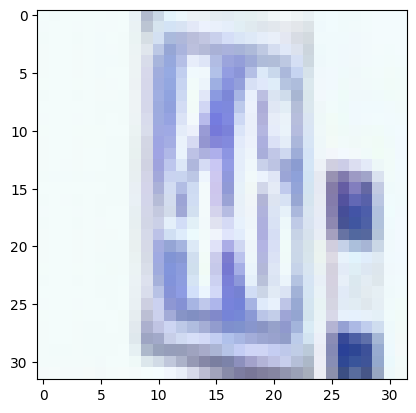

In [7]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

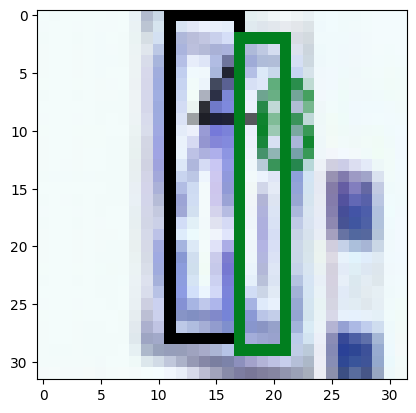

In [8]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [9]:
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [40]:
for batch in dataloader:
    print(batch["bboxes"])
    print(box_convert(batch["bboxes"][0], "xywh", "cxcywh"))
    targets = build_targets(batch["bboxes"], batch["labels"], (2, 2), anchors, 10)

[tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])]
tensor([[0.4533, 0.4565, 0.1963, 0.8696],
        [0.6075, 0.5000, 0.1495, 0.8696]])


In [42]:
targets[0, 0, 0, :], targets[0, 1, 1, :]

(tensor([ 2.2721,  2.3514, -0.0189,  0.0834,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]),
 tensor([ -1.2953, -18.4207,  -0.2908,   0.0834,   1.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,
           0.0000]))

In [105]:
torch.manual_seed(0)

model = MiniYOLOV3(
    image_size=32,
    num_classes=10,
    anchors=anchors,
)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    num_epochs=2000,
    lr=3e-4,
    lambda_coord=5.0,
    lambda_noobj=0.5,
    device="cpu"
)

In [106]:
trainer.train()

100%|██████████| 2000/2000 [00:07<00:00, 280.05it/s, loss=0.0573]


[220.05072021484375,
 215.98448181152344,
 212.2991485595703,
 208.841064453125,
 205.50537109375,
 202.28140258789062,
 199.18109130859375,
 196.2097625732422,
 193.35989379882812,
 190.62144470214844,
 187.99046325683594,
 185.46958923339844,
 183.0639190673828,
 180.77528381347656,
 178.60009765625,
 176.53219604492188,
 174.5655975341797,
 172.69570922851562,
 170.91893005371094,
 169.232666015625,
 167.63536071777344,
 166.12603759765625,
 164.704345703125,
 163.36940002441406,
 162.11827087402344,
 160.94581604003906,
 159.8463134765625,
 158.81483459472656,
 157.84756469726562,
 156.94204711914062,
 156.09463500976562,
 155.30093383789062,
 154.5557403564453,
 153.85487365722656,
 153.1951141357422,
 152.5740509033203,
 151.9890594482422,
 151.4363250732422,
 150.91148376464844,
 150.4109649658203,
 149.93246459960938,
 149.47439575195312,
 149.03524780273438,
 148.61317443847656,
 148.2053680419922,
 147.8096160888672,
 147.42437744140625,
 147.04815673828125,
 146.679992675781

In [107]:
pred = model(batch["images"])
pred.shape

torch.Size([1, 2, 2, 15])

In [108]:
pred[0, 0, 0, :], pred[0, 1, 1, :]

(tensor([  2.2721,   2.3109,  -0.0189,   0.0834,   3.1003, -10.4126, -10.3185,
          -9.9349, -10.4236,   6.0957, -10.3991,  -5.5873, -10.6990, -10.6729,
          -9.9250], grad_fn=<SliceBackward0>),
 tensor([ -1.2953, -18.3745,  -0.2908,   0.0834,   4.6066,  -9.2058,  -9.2918,
          -8.7705,  -9.1059,  -6.0190,  -9.0723,   5.4891,  -9.4461,  -9.4692,
          -8.8785], grad_fn=<SliceBackward0>))

In [109]:
targets[0, 0, 0, :], targets[0, 1, 1, :]

(tensor([ 2.2721,  2.3514, -0.0189,  0.0834,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]),
 tensor([ -1.2953, -18.4207,  -0.2908,   0.0834,   1.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,
           0.0000]))

In [110]:
output = YoloV3Output(pred, model.anchors, 10)

In [111]:
bounding_boxes = output.bounding_boxes()

In [112]:
bounding_boxes

[{'bboxes': tensor([[0.5327, 0.0652, 0.1495, 0.8696],
          [0.3551, 0.0201, 0.1963, 0.8696]], grad_fn=<StackBackward0>),
  'confidence': tensor([4.6066, 3.1003], grad_fn=<SelectBackward0>),
  'labels': tensor([6, 4])}]

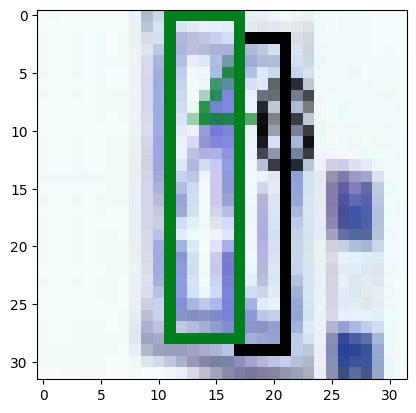

In [113]:
plt.imshow(
    draw_bounding_boxes(batch["images"][0],
                        box_convert(
                            bounding_boxes[0]["bboxes"], 
                            "xywh",
                            "xyxy"
                        ), 
                        bounding_boxes[0]["labels"])
)